# Gradient Boosting
Воспользуемся уже известным нам датасетом с кретдитным скорингом. Воспользуемся результатами предыдущей лабы и возьмем только некоторые фичи согласно WoE and IV. 

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

import matplotlib
import matplotlib.pyplot as plt

train = pd.read_csv('data/application_train.csv', delimiter=',')
test = pd.read_csv('data/application_test.csv', delimiter=',')

In [2]:
plt.style.use('dark_background')

In [21]:
new_train_X = train[['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH',
                      'ORGANIZATION_TYPE', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_LAST_PHONE_CHANGE']]
new_test = test[['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH',
                      'ORGANIZATION_TYPE', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_LAST_PHONE_CHANGE']]

In [22]:
from sklearn import preprocessing
import seaborn as sns
from sklearn.preprocessing import StandardScaler

In [23]:
encoder = preprocessing.OrdinalEncoder(handle_unknown = 'use_encoded_value', unknown_value = -1)
new_train_X['ORGANIZATION_TYPE'] = encoder.fit_transform(new_train_X['ORGANIZATION_TYPE'].fillna('').to_numpy().reshape(-1, 1))
new_test['ORGANIZATION_TYPE'] = encoder.transform(new_test['ORGANIZATION_TYPE'].fillna('').to_numpy().reshape(-1, 1))

<ipython-input-23-67d4e9bcbb1a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_train_X['ORGANIZATION_TYPE'] = encoder.fit_transform(new_train_X['ORGANIZATION_TYPE'].fillna('').to_numpy().reshape(-1, 1))
<ipython-input-23-67d4e9bcbb1a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_test['ORGANIZATION_TYPE'] = encoder.transform(new_test['ORGANIZATION_TYPE'].fillna('').to_numpy().reshape(-1, 1))


In [24]:
new_train_X.fillna(0, inplace = True)
new_test.fillna(0, inplace = True)

/home/maxim/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4462: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


In [25]:
scaler = StandardScaler()
X_train_scal = scaler.fit_transform(new_train_X)
X_test_scal = scaler.transform(new_test)

X_train_pd_scal = pd.DataFrame(X_train_scal, columns=new_train_X.columns)
X_test_pd_scal = pd.DataFrame(scaler.transform(X_test_scal), columns = new_test.columns)

transformer = preprocessing.MaxAbsScaler()
X_train_pd_scal = pd.DataFrame(transformer.fit_transform(X_train_pd_scal),columns=X_train_pd_scal.columns)
X_test_pd_scal = pd.DataFrame(transformer.transform(X_test_pd_scal),columns=X_test_pd_scal.columns)

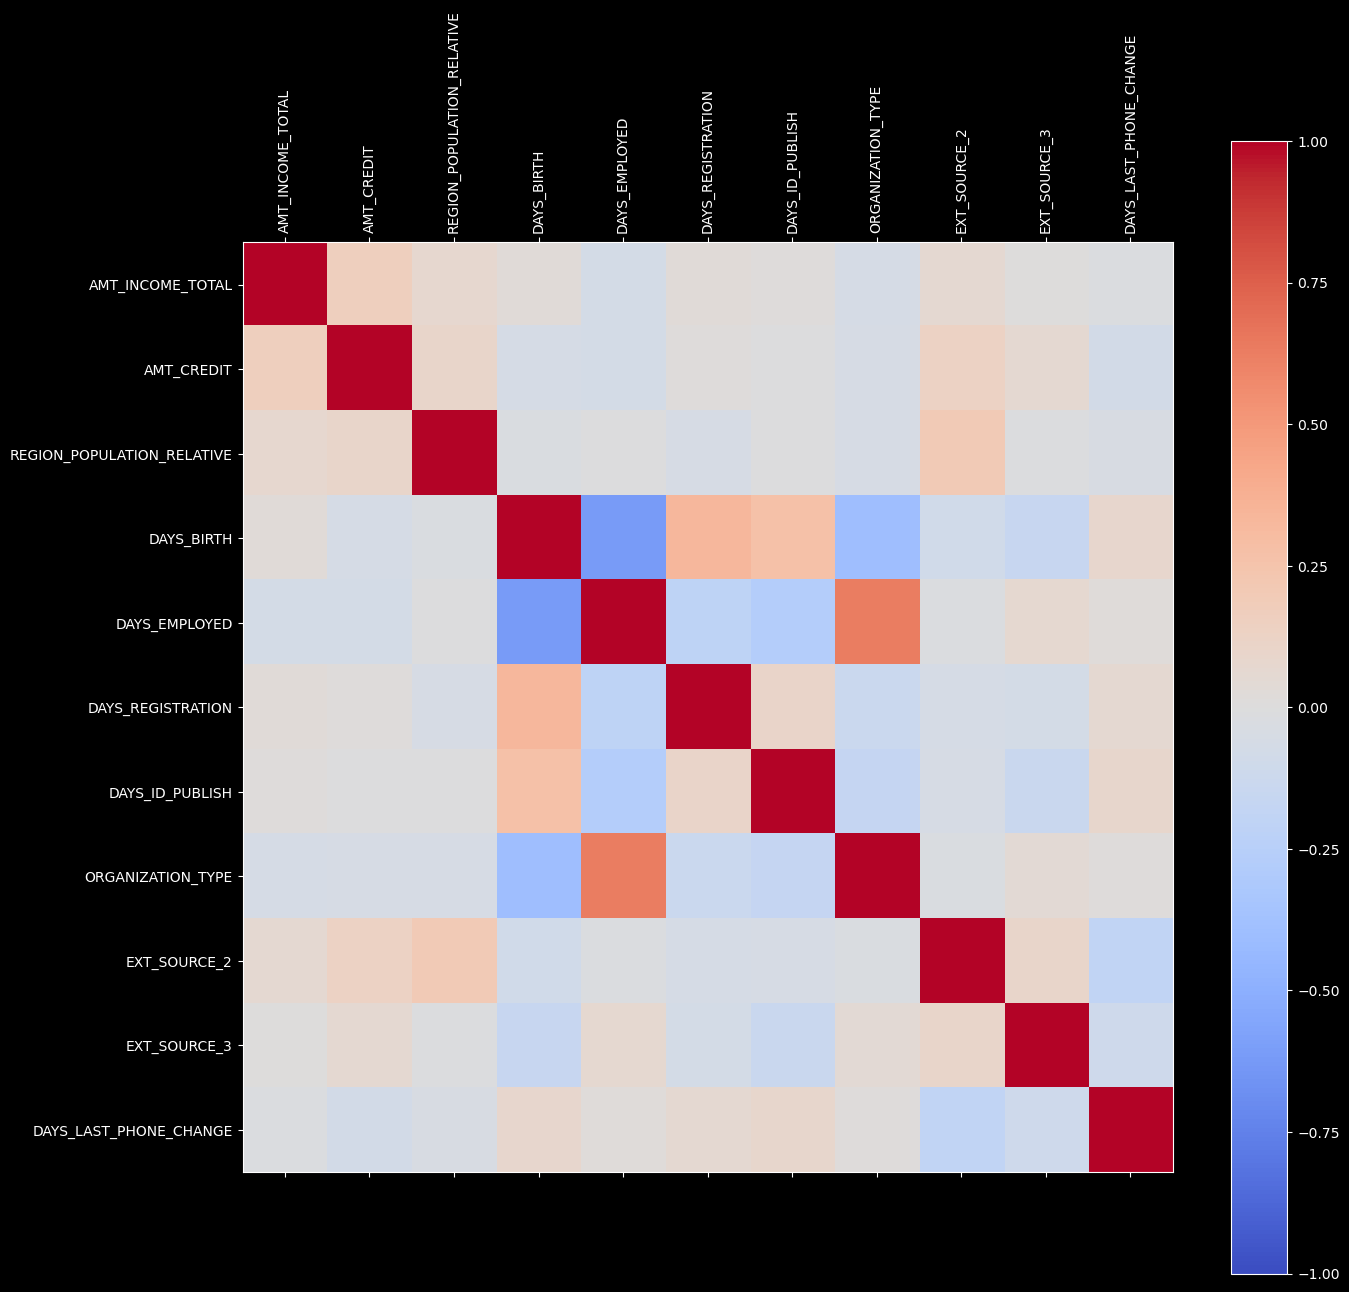

In [26]:
corr = new_train_X.corr()
fig = plt.figure(figsize=[15, 15], dpi=100)
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(new_train_X.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(new_train_X.columns)
ax.set_yticklabels(new_train_X.columns)
plt.show()

In [37]:
import xgboost as xgb
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV

### Будем использовать xgboost и попробуем проварьировать три параметра

In [40]:
def train_model(data, target, param, n_splits = 5):
#     F1_list = []
    roc_auc_list = []
    
    kf = KFold(n_splits = n_splits, shuffle = True)
    for i, (train_index, val_index) in enumerate(kf.split(data)):
#         train_part = data.loc[train_index,:]
#         val_part = data.loc[val_index,:]
        
#         y_train = target[train_index]
#         y_val = target[val_index]
        
        dtrain = xgb.DMatrix(data.loc[train_index,:], label=target[train_index])
        dval = xgb.DMatrix(data.loc[val_index,:], label=target[val_index])
        num_round = 20  # boosting iteration num
        

        bst = xgb.train(param, dtrain, num_round)

        preds = bst.predict(dval)
#         best_preds = np.asarray([np.argmax(line) for line in preds])

#         model = LogisticRegression(class_weight = 'balanced', solver='sag', tol=1e-4, max_iter=5000, random_state=0, C = 1, n_jobs = 4)
        
#         model.fit(X=train_part, y = y_train )
#         val_prediction = model.predict(val_part)
        
        roc_auc = metrics.roc_auc_score(target[val_index], preds)
        roc_auc_list.append(roc_auc)
        print( f'Fold {i}: roc_auc = {roc_auc}')
        
#     print(f'MSLE average = {np.mean(msle_list)} , std ={np.std(msle_list)}  ')
    print(f'roc_auc average = {np.mean(roc_auc_list)} , std ={np.std(roc_auc_list)}  ')
#     print(f'F1 average = {np.mean(F1_list)} , std ={np.std(F1_list)}  ')
    return bst

In [153]:
def full_dataset_train_model(data, target, predict, param, file_name = 'mysubmition.csv'):
    dtrain = xgb.DMatrix(data, label=target)
    dpredict = xgb.DMatrix(predict)
    num_round = 20  # boosting iteration num
    bst = xgb.train(param, dtrain, num_round)
    prob = bst.predict(dpredict)
    sample_submission = pd.read_csv('data/sample_submission.csv')
    sample_submission['TARGET']= prob
    sample_submission.to_csv(file_name, index = False)
    return bst

Вообщем то параметров не так уж и много, будем варьировать lambda, alpha, feature_selector

In [44]:
param = {   'booster' : 'gblinear', #type of model
            'lambda': 0,  # L2 reg
            'alpha': 0, #L1 reg
            'verbosity': 2, #INFO
            'feature_selector': 'cyclic',  # Feature selection and ordering method
            'objective': 'binary:logistic',  # objective function (in this case for binary classification task)
            'eval_metric': 'aucpr'}
train_model(X_train_pd_scal, train.TARGET, param, n_splits = 5)


Fold 0: roc_auc = 0.7000633117838164
Fold 1: roc_auc = 0.7030654119368738
Fold 2: roc_auc = 0.6979975538330285
Fold 3: roc_auc = 0.6921327262132841
Fold 4: roc_auc = 0.6971692072679401
roc_auc average = 0.6980856422069885 , std =0.003605387771239846  


In [64]:
full_dataset_train_model(X_train_pd_scal, train.TARGET, X_test_pd_scal, param, 'grad_boost1.csv')

Our average val score: 0.69809

Kaggle score: 0.63039

In [67]:
param = {   'booster' : 'gblinear', #type of model
            'lambda': 5,  # L2 reg
            'alpha': 0, #L1 reg
            'verbosity': 2, #INFO
            'feature_selector': 'cyclic',  # Feature selection and ordering method
            'objective': 'binary:logistic',  # objective function (in this case for binary classification task)
            'eval_metric': 'aucpr'}  # number of classes
train_model(X_train_pd_scal, train.TARGET, param, n_splits = 5)

full_dataset_train_model(X_train_pd_scal, train.TARGET, X_test_pd_scal, param, 'grad_boost2.csv')

Fold 0: roc_auc = 0.6837236140313319
Fold 1: roc_auc = 0.6731323395576525
Fold 2: roc_auc = 0.6782159795080406
Fold 3: roc_auc = 0.6840268666202347
Fold 4: roc_auc = 0.6870013531195316
roc_auc average = 0.6812200305673581 , std =0.0049397371969881155  


Our average val score: 0.68122

Kaggle score: 0.63037


In [68]:
param = {   'booster' : 'gblinear', #type of model
            'lambda': 0,  # L2 reg
            'alpha': 0, #L1 reg
            'verbosity': 2, #INFO
            'feature_selector': 'shuffle',  # Feature selection and ordering method
            'objective': 'binary:logistic',  # objective function (in this case for binary classification task)
            'eval_metric': 'aucpr'}  # number of classes
train_model(X_train_pd_scal, train.TARGET, param, n_splits = 5)

full_dataset_train_model(X_train_pd_scal, train.TARGET, X_test_pd_scal, param, 'grad_boost3.csv')

Fold 0: roc_auc = 0.7021010450138992
Fold 1: roc_auc = 0.6939551067312228
Fold 2: roc_auc = 0.7005683056655672
Fold 3: roc_auc = 0.697611406918681
Fold 4: roc_auc = 0.6959457431560605
roc_auc average = 0.6980363214970862 , std =0.0029712053197845276  


Our average val score: 0.69804

Kaggle score: 0.63034


In [72]:
param = {   'booster' : 'gblinear', #type of model
            'lambda': 0,  # L2 reg
            'alpha': 0.2, #L1 reg
            'verbosity': 2, #INFO
            'feature_selector': 'cyclic',  # Feature selection and ordering method
            'objective': 'binary:logistic',  # objective function (in this case for binary classification task)
            'eval_metric': 'aucpr'}  # number of classes
train_model(X_train_pd_scal, train.TARGET, param, n_splits = 5)

full_dataset_train_model(X_train_pd_scal, train.TARGET, X_test_pd_scal, param, 'grad_boost4.csv')

Fold 0: roc_auc = 0.5
Fold 1: roc_auc = 0.5
Fold 2: roc_auc = 0.5
Fold 3: roc_auc = 0.5
Fold 4: roc_auc = 0.5
roc_auc average = 0.5 , std =0.0  


In [78]:
dtrain = xgb.DMatrix(X_train_pd_scal, label=train.TARGET)
dpredict = xgb.DMatrix(X_train_pd_scal)
num_round = 20  # boosting iteration num
bst = xgb.train(param, dtrain, num_round)
prob = bst.predict(dpredict)
print(metrics.roc_auc_score(train.TARGET, prob))

0.5


Our average val score: 0.5

Kaggle score: 0.5


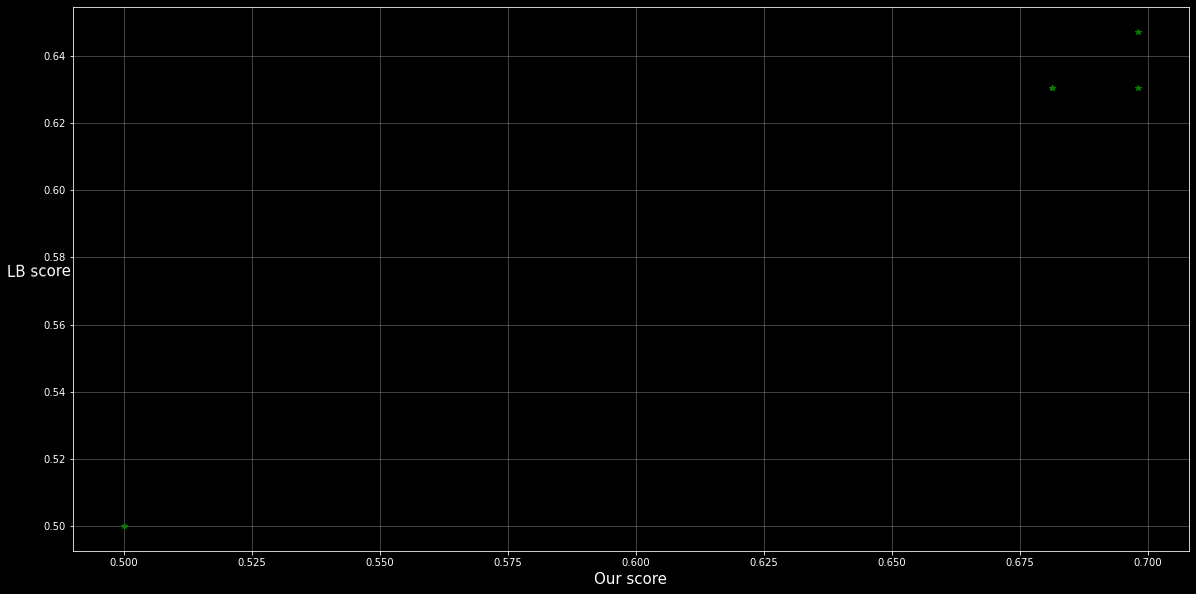

In [75]:
Our_score = np.array([0.69809, 0.68122, 0.68122, 0.69804, 0.5])
LB_score = np.array([0.63039, 0.63037, 0.63034, 0.64718, 0.5])
fig = plt.figure(figsize=[20, 10])
ax = fig.add_subplot(111)
plt.xlabel('Our score',  fontsize = 15)
plt.ylabel('LB score',  fontsize = 15, rotation = 1 )
ax.grid(color="grey", which="major", axis='x', linestyle='-', linewidth=0.5)
ax.grid(color="grey", which="major", axis='y', linestyle='-', linewidth=0.5)
plt.plot(Our_score, LB_score, 'g*')

Как мы видим, при варьировании параметров снижение результата на кросс валидации ведет к снижению результата на лидерборде. Переобучения тут нет. То, что у нас упало до 0.5 это следствие недообучения (видно на скоре той же выборки, что была в обучении).

## GridSearch and RandomizedSearch

In [79]:
from sklearn.model_selection import GridSearchCV

In [121]:
parameters = {
            'learning_rate' : [0.3,0.7,2],
            'random_state' : [0,1,3],
            'reg_lambda': [0,0.5,1.5,3]}

In [122]:
reg = xgb.XGBClassifier(booster = 'gblinear', n_estimators = 20, objective = 'binary:logistic', eval_metric = 'aucpr')
clf = GridSearchCV(reg, parameters, scoring='roc_auc', n_jobs = 4)
clf.fit(X_train_pd_scal, train.TARGET)

/home/maxim/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


GridSearchCV(estimator=XGBClassifier(base_score=None, booster='gblinear',
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False,
                                     eval_metric='aucpr', gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=20, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                          

Посмотрим, какие у нас наилучшие параметры

In [123]:
clf.best_params_

{'learning_rate': 0.3, 'random_state': 3, 'reg_lambda': 0}

In [124]:
clf.best_score_

0.6980595680516432

И выведем результаты кросс валидации (grigcearch умный и сделал все за нас, там по дефолту кфолдс с 5 разбиениями)

In [125]:
clf.cv_results_

{'mean_fit_time': array([ 8.81217861,  9.15736895, 10.07334657,  9.49511976,  9.19729571,
         9.20660138,  9.15240474,  9.91020098,  9.34950185,  8.23314166,
         8.85471907,  7.86060338,  8.37104568,  8.06879125,  8.10524297,
         8.43619156,  8.11641464,  8.18832865,  8.23249111,  7.9409246 ,
         8.13985734,  8.45987911,  7.93772478,  9.81985955,  9.35275278,
         8.18135018,  8.00114808,  7.80099883,  8.66768813,  8.43320913,
         8.43785758,  8.78985491,  9.29531813, 10.21028767, 10.80642829,
         6.80400476]),
 'std_fit_time': array([0.52639042, 0.48657832, 0.60045242, 0.5324431 , 0.5584203 ,
        0.41393491, 0.30089558, 0.31410092, 0.95314818, 0.34453006,
        0.67879661, 0.41208568, 0.54523194, 0.46052075, 0.41343105,
        0.36716407, 0.49403058, 0.38778468, 0.32428392, 0.64601127,
        0.5869647 , 0.62012207, 0.33581612, 0.27191248, 0.60689894,
        0.50456068, 0.37065801, 0.66660516, 0.98864679, 0.49895764,
        0.36547783, 0.897

In [134]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, rv_discrete

In [139]:
distributions = dict(learning_rate=uniform(loc=1, scale=2),
                     reg_lambda=uniform(loc=0, scale=2),
                     random_state=[2,3,4,5])
rc_clf = RandomizedSearchCV(reg, distributions, scoring='roc_auc', n_jobs = 4)
rc_clf.fit(X_train_pd_scal, train.TARGET)

/home/maxim/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


RandomizedSearchCV(estimator=XGBClassifier(base_score=None, booster='gblinear',
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           enable_categorical=False,
                                           eval_metric='aucpr', gamma=None,
                                           gpu_id=None, importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan...
                                           reg_alpha=None, reg_lambda=None,
                                           scale_pos_weight=None,
                                           subsample=None, 

In [140]:
rc_clf.best_params_

{'learning_rate': 1.9484212118149415,
 'random_state': 4,
 'reg_lambda': 0.9153055214607348}

In [141]:
rc_clf.best_score_

0.6879389894720334

In [157]:
param = {
    'max_depth': 5,  # max tree depth
    'eta': 0.3,  # learning rate / step size
    'eval_metric': 'aucpr',
    'lambda' : 1,
    'verbosity': 1}#INFO
train_model(X_train_pd_scal, train.TARGET, param, n_splits = 5)


Fold 0: roc_auc = 0.7277068380951793
Fold 1: roc_auc = 0.7247682243211789
Fold 2: roc_auc = 0.7246312247749618
Fold 3: roc_auc = 0.725549954132056
Fold 4: roc_auc = 0.7268337985585702
roc_auc average = 0.7258980079763893 , std =0.0011958145908036988  


In [154]:
bst = full_dataset_train_model(X_train_pd_scal, train.TARGET, X_test_pd_scal, param, 'grad_boost_tree.csv')

Получили скор на лидерборде: 0.62458

Изобразим  feature importance plot:

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

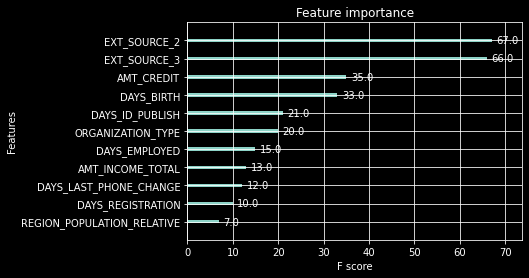

In [155]:
xgb.plot_importance(bst)

Самыми важными оказались данные из сторонних источников (что в целом наверное логично, если там предыдущие кредитные истории)

### Пронаблюдаем все таки переобучение при варьировании гиперпараметров

In [161]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(new_train_X, train.TARGET, test_size=0.35, shuffle = True)

/home/maxim/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/maxim/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/maxim/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: Use

NameError: name 'clear_output' is not defined

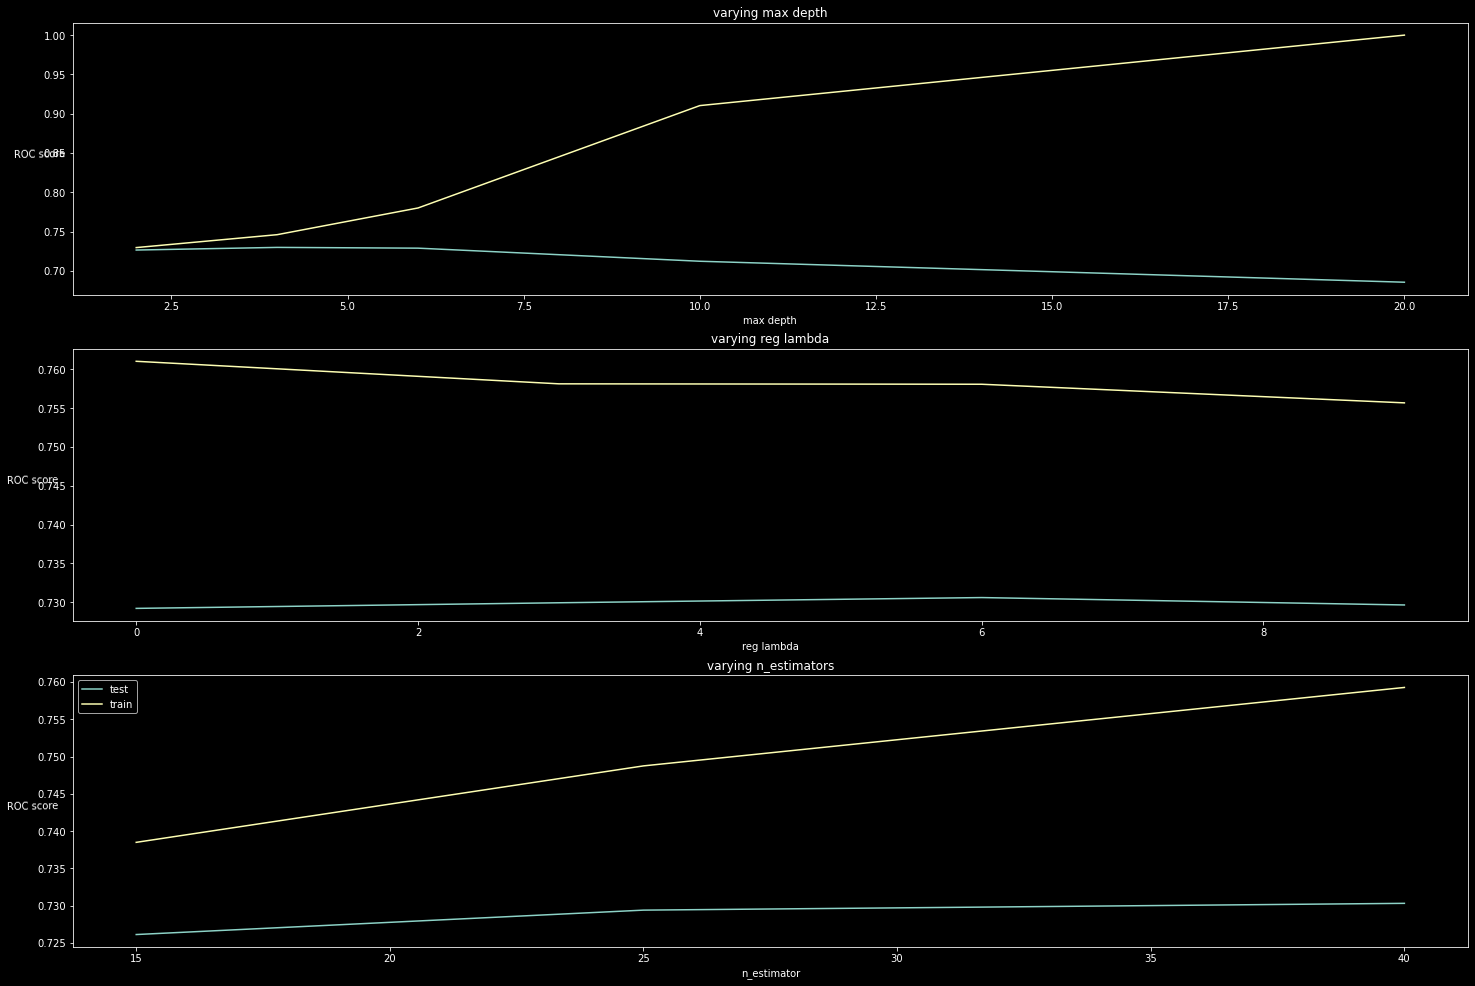

In [197]:
max_depths = [2,4,6,10,20]
reg_lambdas = np.arange(0,10,3)
n_estimatorss = [15,25,40]
roc_auc_list_train = []
roc_auc_list_test = []
fig = plt.figure(figsize=[25, 17])

for max_depth in max_depths:
    clf = xgb.XGBClassifier(n_estimators = 40, max_depth = max_depth, eta = 0.3, eval_metric = 'aucpr', reg_lambda = 1.5, objective = 'binary:logistic')
    clf.fit(X_train, y_train)
    roc_auc = metrics.roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])
    roc_auc_list_test.append(roc_auc)
    roc_auc = metrics.roc_auc_score(y_train, clf.predict_proba(X_train)[:,1])
    roc_auc_list_train.append(roc_auc)
ax = fig.add_subplot(3,1,1).set_title("varying max depth")
plt.xlabel('max depth',  fontsize = 10)
plt.ylabel('ROC score',  fontsize = 10, rotation = 1 )
plt.plot(max_depths, roc_auc_list_test, label = 'test')
plt.plot(max_depths, roc_auc_list_train, label = 'train')

roc_auc_list_train = []
roc_auc_list_test = []
for reg_lambda in reg_lambdas:
    clf2 = xgb.XGBClassifier(n_estimators = 40, max_depth = 5, eta = 0.3, eval_metric = 'aucpr', reg_lambda = reg_lambda, objective = 'binary:logistic')
    clf2.fit(X_train, y_train)
    roc_auc = metrics.roc_auc_score(y_test, clf2.predict_proba(X_test)[:,1])
    roc_auc_list_test.append(roc_auc)
    roc_auc = metrics.roc_auc_score(y_train, clf2.predict_proba(X_train)[:,1])
    roc_auc_list_train.append(roc_auc)
ax = fig.add_subplot(3,1,2).set_title("varying reg lambda")
plt.xlabel('reg lambda',  fontsize = 10)
plt.ylabel('ROC score',  fontsize = 10, rotation = 1 )
plt.plot(reg_lambdas, roc_auc_list_test, label = 'test')
plt.plot(reg_lambdas, roc_auc_list_train, label = 'train')


roc_auc_list_train = []
roc_auc_list_test = []
for n_estimators in n_estimatorss:
    clf3 = xgb.XGBClassifier(n_estimators = n_estimators, max_depth = 5, eta = 0.3, eval_metric = 'aucpr', reg_lambda = 1.5, objective = 'binary:logistic')
    clf3.fit(X_train, y_train)
    roc_auc = metrics.roc_auc_score(y_test, clf3.predict_proba(X_test)[:,1])
    roc_auc_list_test.append(roc_auc)
    roc_auc = metrics.roc_auc_score(y_train, clf3.predict_proba(X_train)[:,1])
    roc_auc_list_train.append(roc_auc)
ax = fig.add_subplot(3,1,3).set_title("varying n_estimators")
plt.xlabel('n_estimator',  fontsize = 10)
plt.ylabel('ROC score',  fontsize = 10, rotation = 1 )
plt.plot(n_estimatorss, roc_auc_list_test, label = 'test')
plt.plot(n_estimatorss, roc_auc_list_train, label = 'train')

plt.legend()
clear_output()
plt.show()

Тут построены графики для варьирования разных гиперпараметров, на каждом есть скор для выборки на которой обучались, и на валидационной. Соответственно глубина дерева больше всего влияет на обучение. Оно и онятно, мы так углубились, что просто стали выучивать отдельные случаи. По графику хорошо видно, что две кривые расходятся, начиная уже с 4.

А вот для регуляризационного параметра такого нет, скорее даже наоборот, мы повышаем параметр, скор на трейне падает, а на валидации сначала растет чуток, потом начинает падать.

Для последнего параметра тоже заметно переобучение, скор на трейне растет быстро, а вот на тесте он останоил свой рост